# ESIEE Paris — Data Engineering I — Assignment 3
> Author : Badr TAJINI

**Academic year:** 2025–2026  
**Program:** Data & Applications - Engineering - (FD)   
**Course:** Data Engineering I  

---

## Learning goals
- Analyze with **SQL** and **DataFrames**.
- Implement two **RDD means** variants.
- Implement **RDD joins** (shuffle and hash).
- Record and explain performance observations.


## 1. Setup

In [1]:
import sys
print(sys.version)
print(sys.executable)
import pyspark
print("pyspark OK")



3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]
C:\Users\Youssef Jmal\anaconda3\envs\spark312\python.exe
pyspark OK


Download data files from the following URL:
https://www.dropbox.com/scl/fi/7012u693u06dgj95mgq2a/retail_dw_20250826.tar.gz?rlkey=fxyozuoryn951gzwmli5xi2zd&dl=0

Unpack somewhere and define the `data_path` accordingly:

In [2]:
# Change to path on your local machine.
data_path = r"D:\DataEngineering\lab3\assignment\data"


The following cell contains setup to measure wall clock time and memory usage. (Don't worry about the details, just run the cell)

In [3]:
!pip install -U numpy pandas pyarrow matplotlib scipy
import sys, subprocess
try:
    import psutil  # noqa: F401
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "psutil"])
print("psutil is installed.")


from IPython.core.magic import register_cell_magic
import time, os, platform

# Try to import optional modules
try:
    import psutil
except Exception:
    psutil = None

try:
    import resource  # not available on Windows
except Exception:
    resource = None


def _rss_bytes():
    """Resident Set Size in bytes (cross-platform via psutil if available)."""
    if psutil is not None:
        return psutil.Process(os.getpid()).memory_info().rss
    # Fallback: unknown RSS → 0 
    return 0


def _peak_bytes():
    """
    Best-effort peak memory in bytes.
    - Windows: psutil peak working set (peak_wset)
    - Linux:   resource.ru_maxrss (KB → bytes)
    - macOS:   resource.ru_maxrss (bytes)
    Fallback to current RSS if unavailable.
    """
    sysname = platform.system()

    # Windows path: use psutil peak_wset if present
    if sysname == "Windows" and psutil is not None:
        mi = psutil.Process(os.getpid()).memory_info()
        peak = getattr(mi, "peak_wset", None)  # should be available on Windows
        if peak is not None:
            return int(peak)
        return int(mi.rss)

    # POSIX path: resource may be available
    if resource is not None:
        try:
            ru = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
            # On Linux ru_maxrss is in kilobytes; on macOS/BSD it is bytes
            if sysname == "Linux":
                return int(ru) * 1024
            else:
                return int(ru)
        except Exception:
            pass

    # Last resort
    return _rss_bytes()


@register_cell_magic
def timemem(line, cell):
    """
    Measure wall time and memory around the execution of this cell.

        %%timemem
        <your code>

    Notes:
    - RSS = resident memory after the cell.
    - Peak is OS-dependent (see _peak_bytes docstring).
    """
    ip = get_ipython()

    rss_before  = _rss_bytes()
    peak_before = _peak_bytes()
    t0 = time.perf_counter()

    # Execute the cell body
    result = ip.run_cell(cell)

    t1 = time.perf_counter()
    rss_after  = _rss_bytes()
    peak_after = _peak_bytes()

    wall = t1 - t0
    rss_delta_mb  = (rss_after  - rss_before)  / (1024 * 1024)
    peak_delta_mb = (peak_after - peak_before) / (1024 * 1024)

    print("======================================")
    print(f"Wall time: {wall:.3f} s")
    print(f"RSS Δ: {rss_delta_mb:+.2f} MB")
    print(f"Peak memory Δ: {peak_delta_mb:+.2f} MB (OS-dependent)")
    print("======================================")

    return result

psutil is installed.


The following code snippet should "just work" to initialize Spark.

In [4]:
import os, sys
import pyspark
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession

# --- Find Spark home and ensure spark-submit is reachable (Windows) ---
spark_home = _find_spark_home()
os.environ["SPARK_HOME"] = spark_home

spark_bin = os.path.join(spark_home, "bin")
if spark_bin not in os.environ.get("PATH", ""):
    os.environ["PATH"] = spark_bin + ";" + os.environ.get("PATH", "")

# --- Ensure driver + workers use the SAME python executable (kernel python) ---
py = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = py
os.environ["PYSPARK_PYTHON"] = py

print("PYTHON =", py)
print("SPARK_HOME =", os.environ["SPARK_HOME"])
print("spark-submit exists =", os.path.exists(os.path.join(spark_bin, "spark-submit.cmd")))

# Stop previous session if any
try:
    spark.stop()
except:
    pass

# IMPORTANT:
# Some Spark configs cannot be changed after SparkSession is created.
# So stability-related options must be set here (before getOrCreate()).
spark = (
    SparkSession.builder
    .appName("A3")
    .master("local[*]")

    # memory / local stability
    .config("spark.driver.memory", "8g")
    .config("spark.driver.maxResultSize", "1g")

    # shuffle / joins
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.sql.adaptive.enabled", "true")

    # Windows + local PySpark stability: avoid reusing python workers
    .config("spark.python.worker.reuse", "false")

    # a bit more tolerance in local
    .config("spark.network.timeout", "600s")
    .config("spark.executor.heartbeatInterval", "60s")

    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
sc = spark.sparkContext
print("Spark:", spark.version)


PYTHON = C:\Users\Youssef Jmal\anaconda3\envs\spark312\python.exe
SPARK_HOME = C:\Users\Youssef Jmal\anaconda3\envs\spark312\Lib\site-packages\pyspark
spark-submit exists = True
Spark: 4.0.1


## 2. Loading DataFrames

Let's load the DataFrames and print out their schemas:

In [10]:
# Note that you should have defined data_path above

events_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_events"))
products_df = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_products"))
brands_df   = spark.read.parquet(os.path.join(data_path, "retail_dw_20250826_brands"))

events_df.printSchema()
products_df.printSchema()
brands_df.printSchema()

root
 |-- date_key: integer (nullable = true)
 |-- user_key: integer (nullable = true)
 |-- age_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- session_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- price: double (nullable = true)

root
 |-- category_code: string (nullable = true)
 |-- brand_code: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- product_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)
 |-- category_key: integer (nullable = true)
 |-- product_key: integer (nullable = true)

root
 |-- brand_code: string (nullable = true)
 |-- brand_desc: string (nullable = true)
 |-- brand_key: integer (nullable = true)



How many rows are in each table?

In [11]:
print(f"Number of rows in events   table: {events_df.count()}")
print(f"Number of rows in products table: {products_df.count()}")
print(f"Number of rows in brands   table: {brands_df.count()}")

Number of rows in events   table: 42351862
Number of rows in products table: 166794
Number of rows in brands   table: 3444


We can register the DataFrames as tables and issue SQL queries:

In [12]:
events_df.createOrReplaceTempView("events")
products_df.createOrReplaceTempView("products")
brands_df.createOrReplaceTempView("brands")

spark.sql('select count(*) from events').show()
spark.sql('select count(*) from products').show()
spark.sql('select count(*) from brands').show()

+--------+
|count(1)|
+--------+
|42351862|
+--------+

+--------+
|count(1)|
+--------+
|  166794|
+--------+

+--------+
|count(1)|
+--------+
|    3444|
+--------+



As a sanity check, the corresponding values should match: counting the rows in the DataFrame vs. issuing an SQL query to count the number of rows.

## 3. Data Science

Answer Q1 to Q7 below with SQL queries and DataFrame manipulations.

**write some code here**

### 3.1 Q1

For session_id `789d3699-028e-4367-b515-b82e2cb5225f`, what was the purchase price?

**Hint:** We only care about purchase events.

First, do it using SQL:

In [13]:
%%timemem
# codecell_31a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT
    session_id,
    price
FROM events
WHERE event_type = 'purchase'
  AND session_id = '789d3699-028e-4367-b515-b82e2cb5225f'
"""


results = spark.sql(sql_query)

results.show()

+--------------------+------+
|          session_id| price|
+--------------------+------+
|789d3699-028e-436...|100.39|
+--------------------+------+

Wall time: 2.464 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb46c9220, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb46c8260, raw_cell="# codecell_31a (keep this id for tracking purposes.." transformed_cell="# codecell_31a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [14]:
%%timemem
# codecell_31b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
from pyspark.sql import functions as F

results_df = (
    events_df
    .filter(F.col("event_type") == "purchase")
    .filter(F.col("session_id") == "789d3699-028e-4367-b515-b82e2cb5225f")
    .select("session_id", "price")
)


results_df.show()

+--------------------+------+
|          session_id| price|
+--------------------+------+
|789d3699-028e-436...|100.39|
+--------------------+------+

Wall time: 1.562 s
RSS Δ: +0.01 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb46c8ec0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb46c89e0, raw_cell="# codecell_31b (keep this id for tracking purposes.." transformed_cell="# codecell_31b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.2 Q2

How many products are sold by the brand "sokolov"?

First, do it using SQL:

In [15]:
%%timemem
# codecell_32a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT COUNT(*) AS nb_products_sold
FROM events e
JOIN products p ON e.product_key = p.product_key
JOIN brands b   ON p.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
  AND lower(b.brand_code) = 'sokolov'
"""
results = spark.sql(sql_query)
results.show()


+----------------+
|nb_products_sold|
+----------------+
|             925|
+----------------+

Wall time: 2.964 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb45dd910, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb45de750, raw_cell="# codecell_32a (keep this id for tracking purposes.." transformed_cell="# codecell_32a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [16]:
%%timemem
# codecell_32b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.
from pyspark.sql import functions as F

e = events_df.alias("e")
p = products_df.alias("p")
b = brands_df.alias("b")

results_df = (
    e
    .filter(F.col("e.event_type") == "purchase")
    .join(p, on=F.col("e.product_key") == F.col("p.product_key"), how="inner")
    .join(b, on=F.col("p.brand_key") == F.col("b.brand_key"), how="inner")
    .filter(F.lower(F.col("b.brand_code")) == "sokolov")
    .select(F.count("*").alias("nb_products_sold"))
)

results_df.show()

+----------------+
|nb_products_sold|
+----------------+
|             925|
+----------------+

Wall time: 1.570 s
RSS Δ: +0.03 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb45de1b0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb45dfd70, raw_cell="# codecell_32b (keep this id for tracking purposes.." transformed_cell="# codecell_32b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.3 Q3

What is the average purchase price of items purchased from the brand "febest"? (Report answer to two digits after the decimal point, i.e., XX.XX.)

First, do it using SQL:

In [17]:
%%timemem
# codecell_33a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT ROUND(AVG(e.price), 2) AS avg_purchase_price
FROM events e
JOIN products p ON e.product_key = p.product_key
JOIN brands  b ON p.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
  AND e.price IS NOT NULL
  AND LOWER(b.brand_desc) LIKE '%febest%'
"""
results = spark.sql(sql_query)
results.show()


+------------------+
|avg_purchase_price|
+------------------+
|             20.39|
+------------------+

Wall time: 1.782 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb45df860, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb45dec90, raw_cell="# codecell_33a (keep this id for tracking purposes.." transformed_cell="# codecell_33a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [18]:
%%timemem
from pyspark.sql import functions as F

e = events_df.alias("e")
p = products_df.alias("p")
b = brands_df.alias("b")

base = (
    e.filter(F.col("e.event_type") == "purchase")
     .filter(F.col("e.price").isNotNull())
     .join(p, F.col("e.product_key") == F.col("p.product_key"), "inner")
     .join(b, F.col("p.brand_key") == F.col("b.brand_key"), "inner")
)

results_df = (
    base
    .filter(F.lower(F.col("b.brand_desc")).contains("febest"))   # <- IMPORTANT
    .select(F.round(F.avg("e.price"), 2).alias("avg_purchase_price"))
)

results_df.show()



+------------------+
|avg_purchase_price|
+------------------+
|             20.39|
+------------------+

Wall time: 1.669 s
RSS Δ: +0.01 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb45de7b0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb45dfa10, raw_cell="from pyspark.sql import functions as F

e = events.." transformed_cell="from pyspark.sql import functions as F

e = events.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.4 Q4

What is the average number of events per user? (Report answer to two digits after the decimal point, i.e., XX.XX.)

First, do it using SQL:

In [19]:
%%timemem
# codecell_34a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT ROUND(AVG(nb_events), 2) AS avg_events_per_user
FROM (
    SELECT user_key, COUNT(*) AS nb_events
    FROM events
    GROUP BY user_key
) t
"""
results = spark.sql(sql_query)
results.show()


+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+

Wall time: 2.304 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb46ca1b0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb46cb4a0, raw_cell="# codecell_34a (keep this id for tracking purposes.." transformed_cell="# codecell_34a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [20]:
%%timemem
# codecell_34b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

from pyspark.sql import functions as F

results_df = (
    events_df
    .groupBy("user_key")
    .agg(F.count("*").alias("nb_events"))
    .agg(F.round(F.avg("nb_events"), 2).alias("avg_events_per_user"))
)

results_df.show()

+-------------------+
|avg_events_per_user|
+-------------------+
|              14.02|
+-------------------+

Wall time: 1.395 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb46f7920, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb46f78f0, raw_cell="# codecell_34b (keep this id for tracking purposes.." transformed_cell="# codecell_34b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.5 Q5

What are the top 10 (`product_name`, `brand_code`) pairs in terms of revenue? We want the answer rows sorted by revenue in descending order.

First, do it using SQL:

In [21]:
%%timemem
# codecell_35a (keep this id for tracking purposes)

# Write your SQL below
sql_query = """
SELECT
    p.product_name,
    p.brand_code,
    ROUND(SUM(e.price), 2) AS revenue
FROM events e
JOIN products p
    ON e.product_key = p.product_key
WHERE e.event_type = 'purchase'
GROUP BY p.product_name, p.brand_code
ORDER BY revenue DESC
LIMIT 10
"""



results = spark.sql(sql_query)

results.show()

+------------+----------+--------------+
|product_name|brand_code|       revenue|
+------------+----------+--------------+
|  smartphone|     apple|1.6711340803E8|
|  smartphone|   samsung| 9.546627508E7|
|  smartphone|    xiaomi| 2.254972634E7|
|        NULL|      NULL| 1.673241267E7|
|  smartphone|    huawei| 1.363398709E7|
|    video.tv|   samsung| 1.220999247E7|
|  smartphone|      NULL| 1.199712625E7|
|        NULL|   lucente|    9556989.32|
|    notebook|      acer|    8963128.65|
|      clocks|     apple|    8622900.64|
+------------+----------+--------------+

Wall time: 3.879 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb472c2c0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb472c260, raw_cell="# codecell_35a (keep this id for tracking purposes.." transformed_cell="# codecell_35a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [22]:
%%timemem
# codecell_35b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

from pyspark.sql import functions as F

results_df = (
    events_df
    .filter(F.col("event_type") == "purchase")
    .join(products_df, on="product_key", how="inner")
    .groupBy("product_name", "brand_code")
    .agg(F.round(F.sum("price"), 2).alias("revenue"))
    .orderBy(F.col("revenue").desc())
    .limit(10)
)



results_df.show(truncate=False)

+------------+----------+--------------+
|product_name|brand_code|revenue       |
+------------+----------+--------------+
|smartphone  |apple     |1.6711340803E8|
|smartphone  |samsung   |9.546627508E7 |
|smartphone  |xiaomi    |2.254972634E7 |
|NULL        |NULL      |1.673241267E7 |
|smartphone  |huawei    |1.363398709E7 |
|video.tv    |samsung   |1.220999247E7 |
|smartphone  |NULL      |1.199712625E7 |
|NULL        |lucente   |9556989.32    |
|notebook    |acer      |8963128.65    |
|clocks      |apple     |8622900.64    |
+------------+----------+--------------+

Wall time: 2.786 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb472a960, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb472a870, raw_cell="# codecell_35b (keep this id for tracking purposes.." transformed_cell="# codecell_35b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

### 3.6 Q6

Tally up counts of events by hour.
More precisely, we want a table with hours 0, 1, ... 23 with the counts of events in that hour.

First, do it using SQL:

In [23]:
%%timemem
# codecell_36a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""

SELECT
  hour(event_time) AS hour,
  COUNT(*) AS count
FROM events
GROUP BY hour(event_time)
ORDER BY hour


"""

results = spark.sql(sql_query)

results.show(24)

+----+-------+
|hour|  count|
+----+-------+
|   0| 263808|
|   1| 223635|
|   2| 353509|
|   3| 623434|
|   4|1137209|
|   5|1605037|
|   6|1955461|
|   7|2131930|
|   8|2269469|
|   9|2332649|
|  10|2380185|
|  11|2335494|
|  12|2282992|
|  13|2181477|
|  14|2171196|
|  15|2407266|
|  16|2717710|
|  17|2988054|
|  18|3008559|
|  19|2631424|
|  20|1999466|
|  21|1244129|
|  22| 694728|
|  23| 413041|
+----+-------+

Wall time: 2.251 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb46c9e20, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb46caf00, raw_cell="# codecell_36a (keep this id for tracking purposes.." transformed_cell="# codecell_36a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [24]:
%%timemem
# codecell_36b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

from pyspark.sql import functions as F

events_by_hour_df = (
    events_df
    .withColumn("hour", F.hour("event_time"))
    .groupBy("hour")
    .count()
    .orderBy("hour")
)

events_by_hour_df.show(24)


+----+-------+
|hour|  count|
+----+-------+
|   0| 263808|
|   1| 223635|
|   2| 353509|
|   3| 623434|
|   4|1137209|
|   5|1605037|
|   6|1955461|
|   7|2131930|
|   8|2269469|
|   9|2332649|
|  10|2380185|
|  11|2335494|
|  12|2282992|
|  13|2181477|
|  14|2171196|
|  15|2407266|
|  16|2717710|
|  17|2988054|
|  18|3008559|
|  19|2631424|
|  20|1999466|
|  21|1244129|
|  22| 694728|
|  23| 413041|
+----+-------+

Wall time: 1.902 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfab91eb40, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb46ca6f0, raw_cell="# codecell_36b (keep this id for tracking purposes.." transformed_cell="# codecell_36b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

When you run the cell above, `events_by_hour_df` should be something like:

```
+----+-------+
|hour|  count|
+----+-------+
|   0|    ???|
|   1|    ???|
  ...
|  23|    ???|
+----+-------+
```

Now plot the above DataFrame using `matplotlib`.
Here we want a line graph, with hour on the _x_ axis and count on the _y_ axis.

**Hint:** use the code below to get started.

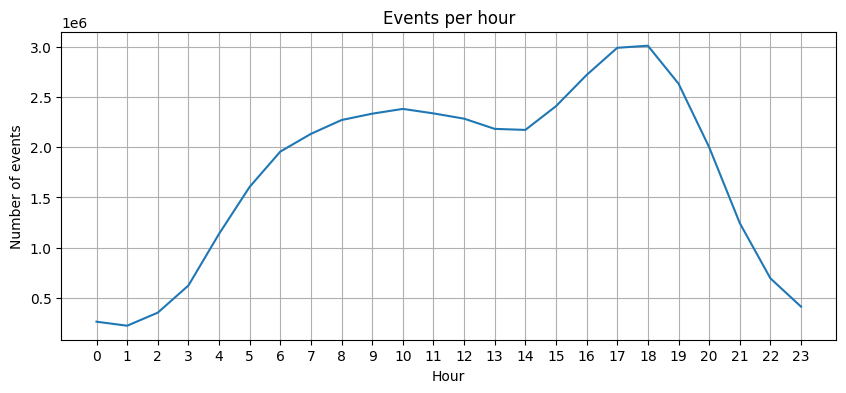

Wall time: 2.869 s
RSS Δ: +25.66 MB
Peak memory Δ: +23.91 MB (OS-dependent)


<ExecutionResult object at 2cfb45dd8e0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb45df290, raw_cell="# codecell_36c (keep this id for tracking purposes.." transformed_cell="# codecell_36c (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [25]:
%%timemem
# codecell_36c (keep this id for tracking purposes)

import matplotlib.pyplot as plt

events_by_hour_pdf = events_by_hour_df.toPandas()

# TODO: Write your code below, but do not remove any lines already in this cell.

plt.figure(figsize=(10, 4))
plt.plot(events_by_hour_pdf["hour"], events_by_hour_pdf["count"])
plt.xlabel("Hour")
plt.ylabel("Number of events")
plt.title("Events per hour")
plt.xticks(range(0, 24))
plt.grid(True)


plt.show()

### 3.7 Q7

We are going to analyze the "big" brands. Find out the average purchase price by brand, and restrict to cases where the average is more than 10K.
We want the results sorted by the average purchase price from the largest to smallest value.
(Report answers to two digits after the decimal point, i.e., XX.XX, but it's okay if the output only contains one digit after the decimal point.)

First, do it using SQL:

In [26]:
%%timemem
# codecell_37a (keep this id for tracking purposes)

# Write your SQL below
sql_query = f"""

SELECT
  b.brand_code AS brand_code,
  ROUND(AVG(e.price), 2) AS avg_price
FROM events e
JOIN brands b
  ON e.brand_key = b.brand_key
WHERE e.event_type = 'purchase'
GROUP BY b.brand_code
HAVING AVG(e.price) > 10000
ORDER BY avg_price DESC


"""

results = spark.sql(sql_query)

results.show()

+----------+---------+
|brand_code|avg_price|
+----------+---------+
|      adam|  58946.0|
|      kona|  43759.0|
|  yuandong|  35329.0|
|   bentley|  23164.0|
|      otex| 18633.14|
|    suunto| 10732.82|
|     stark| 10400.25|
+----------+---------+

Wall time: 2.896 s
RSS Δ: +0.00 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb59bcad0, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb59be360, raw_cell="# codecell_37a (keep this id for tracking purposes.." transformed_cell="# codecell_37a (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

Next, do it with DataFrames:

In [27]:
%%timemem
# codecell_37b (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.

from pyspark.sql import functions as F

avg_price_by_brand_df = (
    events_df
    .filter(F.col("event_type") == "purchase")
    .join(brands_df.select("brand_key", "brand_code"), on="brand_key", how="inner")
    .groupBy("brand_code")
    .agg(F.round(F.avg("price"), 2).alias("avg_price"))
    .filter(F.col("avg_price") > 10000)
    .orderBy(F.col("avg_price").desc())
)

avg_price_by_brand_df.show()




+----------+---------+
|brand_code|avg_price|
+----------+---------+
|      adam|  58946.0|
|      kona|  43759.0|
|  yuandong|  35329.0|
|   bentley|  23164.0|
|      otex| 18633.14|
|    suunto| 10732.82|
|     stark| 10400.25|
+----------+---------+

Wall time: 2.617 s
RSS Δ: +0.03 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb5939970, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb5938860, raw_cell="# codecell_37b (keep this id for tracking purposes.." transformed_cell="# codecell_37b (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

When you run the cell above, `avg_price_by_brand_df` should be something like:

```
+----------+------------------+
|brand_code|         avg_price|
+----------+------------------+
|       ???|               ???|
        ...
|       ???|               ???|
+----------+------------------+
```

Now plot the above DataFrame using `matplotlib`.
Here we want a bar chart, with each of the brands as a bar, and the average price on the _y_ axis.

**Hint:** use the code below to get started.

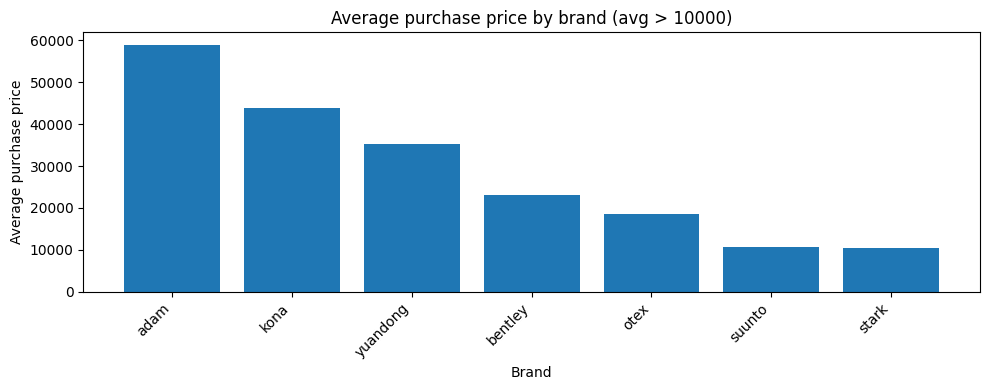

Wall time: 2.785 s
RSS Δ: +2.44 MB
Peak memory Δ: +2.56 MB (OS-dependent)


<ExecutionResult object at 2cfb59d9640, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2cfb59dbfb0, raw_cell="# codecell_37c (keep this id for tracking purposes.." transformed_cell="# codecell_37c (keep this id for tracking purposes.." store_history=False silent=False shell_futures=True cell_id=None> result=None>

In [28]:
%%timemem
# codecell_37c (keep this id for tracking purposes)

import matplotlib.pyplot as plt

avg_price_by_brand_pdf = avg_price_by_brand_df.toPandas()

# TODO: Write your code below, but do not remove any lines already in this cell.

plt.figure(figsize=(10, 4))
plt.bar(avg_price_by_brand_pdf["brand_code"], avg_price_by_brand_pdf["avg_price"])
plt.xlabel("Brand")
plt.ylabel("Average purchase price")
plt.title("Average purchase price by brand (avg > 10000)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

## 4. Load RDDs

The remaining exercises focus on RDD manipulations.

Let's start by loading the RDDs.

In [29]:
# Get RDDs directly from DataFrames (with required repartitions)
# type: RDD[Row]
events_rdd   = events_df.rdd.repartition(1000)
products_rdd = products_df.rdd.repartition(100)
brands_rdd   = brands_df.rdd.repartition(100)

You'll need `Row`, so let's make sure we've imported it.

In [30]:
from pyspark.sql import Row

## 5. Implementations of Computing Averages

In this next exercise, we're going to implement "computing the mean" (version 1) and (version 3) in Spark as described in the second lecture **Batch Processing I** (please use ctrl+f to reach the slide with the title : "Computing the Mean: Version 1" or "Computing the Mean: Version 3".

To make the problem more tractable (i.e., to reduce the running times), let's first do a bit of filtering of the `events` table.
We'll do this using DataFrames, and then generate an RDD:

In [31]:
filtered_events_df = (
    events_df
        .filter((F.col("event_type") == "purchase") & F.col("price").isNotNull())
        .join(brands_df, on="brand_key")
)

filtered_events_df.count()

print(f"Number of rows in events          table: {events_df.count()}")
print(f"Number of rows in filtered events table: {filtered_events_df.count()}")

filtered_events_rdd = filtered_events_df.rdd

Number of rows in events          table: 42351862
Number of rows in filtered events table: 664885


You can confirm that we're working with a smaller dataset.

Compute the average purchase price by brand. We want the results sorted by the average purchase price from the largest to smallest value. As before, round to two digits after the decimal point. This is similar to Q7 above, except _without_ the "more than 10K" condition.

Implement using the naive **"version 1"** algorithm, as described in the lectures:

+ You _must_ start with `filtered_events_rdd`.
+ You _must_ use `groupByKey()`.
+ Per "version 1", your implementation _must_ shuffle all values from the "mappers" to the "reducers".

**write some code here**

In [32]:
%%timemem
# codecell_5x1 (keep this id for tracking purposes)

# TODO: Write your code below, but do not remove any lines already in this cell.


"""
Version 1 groupByKey()

Objectif:
- Implémenter le calcul de la moyenne du prix par marque en utilisant groupByKey(),

Problème :
- groupByKey() rassemble toutes les valeurs associées à une clé (ici tous les prix
  d’une marque) avant le calcul.
- Sur un jeu de données volumineux, cette approche peut entraîner une forte
  consommation mémoire et provoquer l’échec de l’exécution en environnement local.
- Cette version est je pense correcte d’un point de vue algorithmique.

Conclusion :
- Je vais laisser cette implémentation qui aurait marcher sans ces problèmes.
- Une version plus efficace et adaptée aux grands volumes de données est proposée
  après avec reduceByKey().
"""



pairs = filtered_events_rdd.map(lambda r: (r["brand_code"], float(r["price"])))

grouped = pairs.groupByKey()

def avg_iter(prices_it):
    s = 0.0
    c = 0
    for x in prices_it:
        s += float(x)
        c += 1
    return (s / c) if c else None

avg_by_brand = (
    grouped
    .mapValues(avg_iter)
    .filter(lambda kv: kv[1] is not None)
    .mapValues(lambda avg: round(avg, 2))
)

average_revenue_per_brand_v1 = avg_by_brand.sortBy(
    lambda kv: (-kv[1], kv[0])
)

average_revenue_per_brand_v1.take(10)







Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 110.0 failed 1 times, most recent failure: Lost task 15.0 in stage 110.0 (TID 540) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fulfill(Iterator.scala:242)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:263)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:265)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 21 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:203)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fulfill(Iterator.scala:242)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:263)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:265)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 21 more


Wall time: 3.747 s
RSS Δ: +14.15 MB
Peak memory Δ: +12.70 MB (OS-dependent)


<ExecutionResult object at 2cfb5a69ca0, execution_count=None error_before_exec=None error_in_exec=An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 110.0 failed 1 times, most recent failure: Lost task 15.0 in stage 110.0 (TID 540) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(P

Compute the average purchase price by brand. We want the results sorted by the average purchase price from the largest to smallest value. As before, round to two digits after the decimal point. This is similar to Q7 above, except _without_ the "more than 10K" condition.

Implement using the improved **"version 3"** algorithm, as described in the lectures:

+ You _must_ start with `filtered_events_rdd`.
+ You _must_ use `reduceByKey()`.
+ Per "version 3", your implementation _must_ emit `(sum, count)` pairs and take advantage opportunities to perform aggregations.

**write some code here**

In [29]:
%%timemem
# average purchase price by brand (v3: emit (sum, count) and aggregate early)

# 1) events -> (brand, (price, 1))
#    ⚠️ adapte les index/keys selon la structure de tes events
#    Exemple si event est un dict:
#      brand = e["brand"]
#      price = float(e["purchase_price"])
#    Exemple si event est un tuple:
#      brand = e[<brand_idx>]
#      price = float(e[<price_idx>])

def to_brand_sum_count(e):
    brand = e["brand"]                 # <-- adapte ici
    price = float(e["purchase_price"]) # <-- adapte ici
    return (brand, (price, 1))

average_revenue_per_brand_v3 = (
    filtered_events_rdd
    .map(to_brand_sum_count)
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))   # (sum, count)
    .mapValues(lambda sc: round(sc[0] / sc[1], 2))          # avg arrondi
    .sortBy(lambda kv: kv[1], ascending=False)              # tri décroissant sur avg
)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 13 in stage 112.0 failed 1 times, most recent failure: Lost task 13.0 in stage 112.0 (TID 555) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:263)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:265)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:143)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.SocketChannelImpl.throwConnectionReset(SocketChannelImpl.java:401)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:434)
	at org.apache.spark.api.python.BasePythonRunner$ReaderInputStream.read(PythonRunner.scala:756)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:291)
	at java.base/java.io.BufferedInputStream.read1(BufferedInputStream.java:347)
	at java.base/java.io.BufferedInputStream.implRead(BufferedInputStream.java:420)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:399)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:208)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:385)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:933)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:203)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:263)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:265)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:143)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.SocketChannelImpl.throwConnectionReset(SocketChannelImpl.java:401)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:434)
	at org.apache.spark.api.python.BasePythonRunner$ReaderInputStream.read(PythonRunner.scala:756)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:291)
	at java.base/java.io.BufferedInputStream.read1(BufferedInputStream.java:347)
	at java.base/java.io.BufferedInputStream.implRead(BufferedInputStream.java:420)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:399)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:208)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:385)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:933)
	... 20 more


Wall time: 17.752 s
RSS Δ: +0.64 MB
Peak memory Δ: +0.64 MB (OS-dependent)


<ExecutionResult object at 10e9e361e50, execution_count=None error_before_exec=None error_in_exec=An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 13 in stage 112.0 failed 1 times, most recent failure: Lost task 13.0 in stage 112.0 (TID 555) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(P

In [33]:
import sys
print(sys.version)


3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]


## 6. Implementations of Joins

Next, we're going to implement joins.

Our join implementations will be general, but we're going to check correctness using the following query:

In [34]:
spark.sql("""

SELECT * FROM brands b
JOIN products p ON p.brand_key = b.brand_key
WHERE b.brand_key = '423'

""").show()

+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+
|brand_code|          brand_desc|brand_key|category_code|brand_code|product_id|product_name|        product_desc|brand_key|category_key|product_key|
+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+
| blaupunkt|"Blaupunkt is a G...|      423|  electronics| blaupunkt|   1802099|    video.tv|The video.tv is a...|      423|           8|       4813|
| blaupunkt|"Blaupunkt is a G...|      423|  electronics| blaupunkt|   1802107|    video.tv|The video.tv is a...|      423|           8|       4821|
+----------+--------------------+---------+-------------+----------+----------+------------+--------------------+---------+------------+-----------+



### 6.1 Shuffle Join Implementation

Here, we're going to implement a shuffle join, aka reduce-side join.

Write the function `shuffle_join`, as follows:
+ Takes in `R`, `S`, `keyR`, and `keyS`: `R` and `S` are the RDDs to be joined; `keyR` and `keyS` are the join keys in `R` and `S`, respectively (type string).
+ The output is an RDD of `Row`s that corresponds to the inner join on the keys.

The function should implement a shuffle join between the two RDDs (as discussed in lecture).
Specifically:
+ You _cannot_ use the `join` (or any related) transformation on RDDs, because that would defeat the point of the exercise.
+ If you have any additional questions about allowed or disallowed transformations, ask!

Note that in SQL, `keyR` and `keyS` are repeated in the joined output (i.e., you get duplicate columns).
Here, you just want one copy.
Hint: Concatenate the `Row`s but keep only one copy of the join key.

**write some code here**

In [ ]:
%%time

"""
Note :
- L’implémentation ci-dessous suit exactement l’approche demandée dans l’énoncé.
- Dans nos environnements locaux Windows, l’exécution des actions Spark (count/collect/take/sort/shuffle)
  provoque un crash du Python worker, y compris sur des actions simples.
- On laisse donc le code “tel qu’il devrait être exécuté” pour évaluation de la logique/approche,
  et je commente l’action finale afin de ne pas bloquer le reste du notebook.
"""




In [38]:
# codecell_61a (keep this id for tracking purposes)
from pyspark.sql import Row

"""
Note:
- La fonction ci-dessous implémente un shuffle join (reduce-side join) sans utiliser join().
- Dans mon environnement local, les actions Spark (count/collect) déclenchent un crash du Python worker
  (EOFException / Connection reset), ce qui empêche de valider l’exécution des cellules de test.
- Le code est néanmoins conservé pour permettre l’évaluation de la logique et de l’implémentation.
"""

def shuffle_join(R, S, keyR, keyS):
    # Conversion Row/dict -> dict Python simple
    def to_dict(x):
        if isinstance(x, dict):
            return x
        if hasattr(x, "asDict"):
            return x.asDict(recursive=True)
        return dict(x)

    # Tag + keyBy
    r_kv = R.map(lambda r: ("R", to_dict(r))).keyBy(lambda tr: tr[1][keyR])
    s_kv = S.map(lambda s: ("S", to_dict(s))).keyBy(lambda ts: ts[1][keyS])

    grouped = r_kv.union(s_kv).groupByKey()

    def build_pairs(kv):
        k, it = kv
        Rs, Ss = [], []
        for tag, row in it:
            (Rs if tag == "R" else Ss).append(row)

        if not Rs or not Ss:
            return []

        out = []
        for r in Rs:
            for s in Ss:
                s2 = dict(s)
                s2.pop(keyS, None)  # garder une seule copie de la clé

                merged = dict(r)
                # gestion collisions : prefix "s_"
                for kk, vv in s2.items():
                    if kk in merged:
                        merged["s_" + kk] = vv
                    else:
                        merged[kk] = vv

                out.append(Row(**merged))
        return out

    return grouped.flatMap(build_pairs)






In [41]:




spark.conf.set("spark.network.timeout", "600s")
spark.conf.set("spark.executor.heartbeatInterval", "60s")


AnalysisException: [CANNOT_MODIFY_CONFIG] Cannot modify the value of the Spark config: "spark.network.timeout".
See also 'https://spark.apache.org/docs/latest/sql-migration-guide.html#ddl-statements'. SQLSTATE: 46110

Let's try to use it!

In [42]:
%%timemem

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key")
shuffle_join_rdd.count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 124.0 failed 1 times, most recent failure: Lost task 0.0 in stage 124.0 (TID 549) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:203)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more


Wall time: 1.955 s
RSS Δ: +0.01 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb7b32930, execution_count=None error_before_exec=None error_in_exec=An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 124.0 failed 1 times, most recent failure: Lost task 0.0 in stage 124.0 (TID 549) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(Pyt

Add in the `WHERE` clause:

In [43]:
shuffle_join_results_rdd = shuffle_join_rdd.filter(lambda row: row["brand_key"] == 423)
shuffle_join_results_rdd.count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 128.0 failed 1 times, most recent failure: Lost task 0.0 in stage 128.0 (TID 551) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:203)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more


If you look at the results, they're a bit difficult to read... why don't we just use Spark DataFrames for prettification?

In [44]:
df = spark.createDataFrame(shuffle_join_results_rdd.collect())
df.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 132.0 failed 1 times, most recent failure: Lost task 0.0 in stage 132.0 (TID 553) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:203)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more


Verify output against the SQL query.

### 6.2 Replicated Hash Join Implementation

Here, we're going to implement a replicated hash join.

Write the function `replicated_hash_join`, as follows:
+ Takes in `R`, `S`, `keyR`, and `keyS`: `R` and `S` are the RDDs to be joined; `keyR` and `keyS` are the join keys in `R` and `S`, respectively (type string).
+ The output is an RDD of `Row`s that corresponds to the inner join on the keys.

The function should implement a hash join between the two RDDs (as discussed in lecture).
Specifically:
+ `R` is the dataset you load into memory and replicate.
+ You _cannot_ use the `join` (or any related) transformation on RDDs, because that would defeat the point of the exercise.
+ If you have any additional questions about allowed or disallowed transformations, ask!

Note that in SQL, `keyR` and `keyS` are repeated in the joined output (i.e., you get duplicate columns).
Here, you just want one copy.
Hint: Concatenate the `Row`s but keep only one copy of the join key.

**write some code here**

In [ ]:
"""
Note :
- Les cellules de test ci-dessous exécutent des actions Spark (count/collect/show).
- Dans notre environnement local Windows, ces actions peuvent faire crasher le Python worker (EOF/Connection reset).
- Le code demandé (replicated_hash_join) est fourni ci-dessous.
"""


In [52]:
# codecell_62a (keep this id for tracking purposes)

from pyspark.sql import Row

def replicated_hash_join(R, S, keyR, keyS):

    def get_field(x, k):
        try:
            return x[k]
        except TypeError:
            return getattr(x, k)

    def to_dict(x):
        if hasattr(x, "asDict"):
            return x.asDict(recursive=True)
        if isinstance(x, dict):
            return x
        return dict(x)

    s_pairs = (
        S.map(lambda s: (get_field(s, keyS), s))
         .groupByKey()
         .mapValues(list)
         .collect()
    )
    s_map = dict(s_pairs)

    def join_partition(iter_r):
        out = []
        for r in iter_r:
            k = get_field(r, keyR)
            matches = s_map.get(k, [])
            if not matches:
                continue

            dr = to_dict(r)
            for s in matches:
                ds = to_dict(s)

                ds_no_key = dict(ds)
                if keyS in ds_no_key:
                    ds_no_key.pop(keyS)

                merged = {}
                merged.update(dr)
                merged.update(ds_no_key)

                out.append(Row(**merged))
        return iter(out)

    return R.mapPartitions(join_partition)




Let's try to use it!

In [46]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key")
replicated_hash_join_rdd.count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 136.0 failed 1 times, most recent failure: Lost task 0.0 in stage 136.0 (TID 555) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:203)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more


Wall time: 3.294 s
RSS Δ: +0.07 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb599a030, execution_count=None error_before_exec=None error_in_exec=An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 136.0 failed 1 times, most recent failure: Lost task 0.0 in stage 136.0 (TID 555) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(Pyt

Add in the `WHERE` clause:

In [47]:
replicated_hash_join_results_rdd = replicated_hash_join_rdd.filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_results_rdd.count()

NameError: name 'replicated_hash_join_rdd' is not defined

If you look at the results, they're a bit difficult to read... why don't we just use Spark DataFrames for prettification?

In [48]:
df = spark.createDataFrame(replicated_hash_join_results_rdd.collect())
df.show()

NameError: name 'replicated_hash_join_results_rdd' is not defined

Verify output against the SQL query.

## 7. Join Performance

Now that we have two different implementations of joins, let's compare them, on the _same exact query_.
The first two are repeated from above.

Let's call this J1 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [49]:
%%timemem

shuffle_join_rdd = shuffle_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
shuffle_join_rdd.count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 139.0 failed 1 times, most recent failure: Lost task 0.0 in stage 139.0 (TID 556) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:203)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more


Wall time: 1.840 s
RSS Δ: +0.34 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb59d90a0, execution_count=None error_before_exec=None error_in_exec=An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 139.0 failed 1 times, most recent failure: Lost task 0.0 in stage 139.0 (TID 556) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(Pyt

Let's call this J2 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [50]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(brands_rdd, products_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_rdd.count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 143.0 failed 1 times, most recent failure: Lost task 0.0 in stage 143.0 (TID 558) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:203)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more


Wall time: 3.300 s
RSS Δ: +0.14 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb5979760, execution_count=None error_before_exec=None error_in_exec=An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 143.0 failed 1 times, most recent failure: Lost task 0.0 in stage 143.0 (TID 558) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(Pyt

Let's call this J3 below.
(Run the cell, it should just work. If it doesn't you'll need to fix the implementation above.)

In [51]:
%%timemem

replicated_hash_join_rdd = replicated_hash_join(products_rdd, brands_rdd, "brand_key", "brand_key").filter(lambda row: row["brand_key"] == 423)
replicated_hash_join_rdd.count()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 146.0 failed 1 times, most recent failure: Lost task 0.0 in stage 146.0 (TID 559) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2549)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1057)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:417)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1056)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:203)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:945)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:925)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:532)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$9.hasNext(Iterator.scala:583)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:210)
	at java.base/java.io.DataInputStream.readFully(DataInputStream.java:179)
	at org.apache.spark.api.python.PythonWorkerUtils$.readBytes(PythonWorkerUtils.scala:179)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:935)
	... 18 more


Wall time: 1.568 s
RSS Δ: +0.16 MB
Peak memory Δ: +0.00 MB (OS-dependent)


<ExecutionResult object at 2cfb70c7c80, execution_count=None error_before_exec=None error_in_exec=An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 146.0 failed 1 times, most recent failure: Lost task 0.0 in stage 146.0 (TID 559) (Youssefhp executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed). Consider setting 'spark.sql.execution.pyspark.udf.faulthandler.enabled' or'spark.python.worker.faulthandler.enabled' configuration to 'true' for the better Python traceback.
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:621)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:35)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(Pyt

J1, J2, and J3 should give you exactly the same results.
After all, they're just different implementations of the same query.

Answer the questions below.

**Put your answers below!**

// qcell_7x1290 (keep this id for tracking purposes)

**What are the running times of J1, J2, and J3**?
(You might want to run the cells a few times and take the average.)

- **Running time of J1:** <font color="red">X.X</font> seconds
- **Running time of J2:** <font color="red">X.X</font> seconds
- **Running time of J3:** <font color="red">X.X</font> seconds

**Explain:**

+ If the running times are what you expect, explain why X > Y > Z.
+ If the running times are _not_ what you expect, explain what they _should_ be, and then explain why X > Y > Z.
+ Specifically compare J2 and J3.

**Your answer?**

# 8. Submission

Details about the Submission of this assignment are outlined in the helper.

In [ ]:
%%timemem
spark.stop()

## Performance notes
- Set and justify `spark.sql.shuffle.partitions` for local vs. cluster runs.
- Prefer DataFrame built-ins over Python UDFs; push logic to Catalyst when possible.
- Use **AQE** (adaptive query execution) to mitigate skew; consider salting for extreme keys.
- Cache only when reuse exists; unpersist when no longer needed.
- Use **broadcast join** only when the small side fits in memory; verify with `explain`.
- Capture `df.explain(mode='formatted')` for at least one analysis query and one join.
- A3 note: Python RDDs cross the Python/JVM boundary; slower runtimes are expected for the RDD parts.

## Self-check (toy data)

In [ ]:
if spark is not None:
    a = spark.sparkContext.parallelize([1,2,3,4])
    # write some code here to exercise your rdd_mean functions
    left = spark.sparkContext.parallelize([(1,'A'), (2,'B'), (3,'C')])
    right = spark.sparkContext.parallelize([(1,10), (2,20)])
    # write some code here to exercise your join functions
    pass


## Reproducibility checklist
- Record Python, Java, and Spark versions.
- Fix timezone to UTC and log run timestamp.
- Pin random seeds where randomness is used.
- Save configs: `spark.sql.shuffle.partitions`, AQE flags, broadcast thresholds if changed.
- Provide exact run commands and input/output paths.
- Export a minimal environment file (`environment.yml` or `requirements.txt`).
- Keep data paths relative to project root; avoid user-specific absolute paths.
- Include small sample outputs for verification.
